In [106]:
import numpy as np 
import matplotlib.pyplot as plt

$$\begin{cases}
&\partial_t\rho +\partial_x(\rho u) = 0\\
&\partial_t(\rho u) + \partial_x (\rho u^2) = 0
\end{cases}$$

# Condition initiale

In [107]:
def init(x):
    n = len(x)
    rho0 = np.ones(n)*1e-20
    u0 = np.ones(n)*1e-20
    for i in range(n):
        if x[i]<-1 and x[i]>-2:
            rho0[i] = 2
            u0[i] = 1
        if x[i]<5 and x[i]>1:
            rho0[i] = 1
            u0[i] = -1
    return rho0,u0

# Fonction de flux

In [108]:
def flux(rho,u):
    f1 = u
    f2 = u*u/rho
    return f1,f2

# Flux de Godunov

In [109]:
def Godunov(rho_l,rho_r,u_l,u_r,f_rho_l,f_rho_r,f_rhou_l,f_rhou_r):
    u_hat = (np.sqrt(rho_l)*u_l+np.sqrt(rho_r)*u_r)/(np.sqrt(rho_l)+np.sqrt(rho_r))
    if u_l<0 and u_r>0:
        f_r = 0
        f_ru = 0
        return f_r,f_ru
    elif u_hat>1e-10:
        f_r = f_rho_l
        f_ru = f_rhou_l
        return f_r,f_ru
    elif u_hat < 0:
        f_r = f_rho_r
        f_ru = f_rhou_r
        return f_r,f_ru
    elif u_hat > 0 and u_hat < 1e-10:
        f_r = (f_rho_l+f_rho_r)/2
        f_ru = (f_rhou_l+f_rhou_r)/2
        return f_r,f_ru

# Tracer la condition initiale

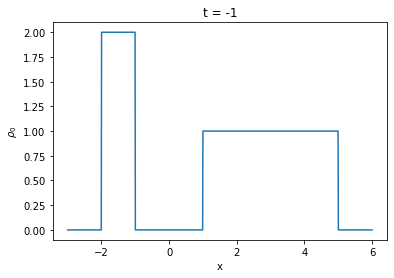

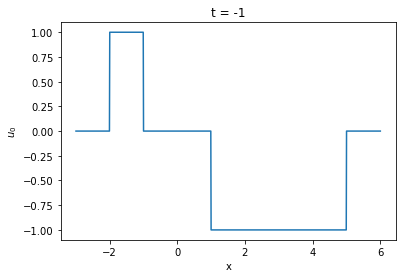

In [110]:
# Discretisation de l'espace
a = -3
b = 6
N = 1000
dx = (b-a)/N
x = np.arange(-3+1/2*dx,6+dx/2,dx)
rho0,u0 = init(x)

plt.plot(x,rho0)
plt.title('t = -1')
plt.xlabel('x')
plt.ylabel(r'$\rho_0$')

plt.figure(2)
plt.plot(x,u0)
plt.title('t = -1')
plt.xlabel('x')
plt.ylabel(r'$u_0$')
plt.show()

# Solution exacte

In [111]:
def sol_ex(x,t):
    N = len(x)
    rho_ex = np.zeros(N)
    rhou_ex = np.zeros(N)
    u_hat = (np.sqrt(2)-1)/(np.sqrt(2)+1)
    if t<=0:  # les 2 nuages n'est pas encore rencontre
        for i in range(N):
            if x[i] > t-1 and x[i] < t:
                rho_ex[i] = 2
                rhou_ex[i] = 2
            if x[i] > -t and x[i] < 4-t:
                rho_ex[i] = 1
                rhou_ex[i] = -1
    elif t>0 and t<=(np.sqrt(2)+1)/2:   # les 2 nuages se rencontre
        for i in range(N):
            if t-1 <= x[i] and x[i]<u_hat*t:
                rho_ex[i] = 2
                rhou_ex[i] = 2
            elif x[i-1]<u_hat*t and x[i]>=u_hat*t:
                rho_ex[i] = 2+(2*(1-u_hat)+(u_hat+1))*t*5
                rhou_ex[i] = 2+(2*(1-u_hat)-(u_hat+1))*t*5 
            elif x[i]>u_hat*t and x[i] < 4-t:
                rho_ex[i] = 1
                rhou_ex[i] = -1
    elif t>(np.sqrt(2)+1)/2 and t<4.25:
        for i in range(N):
            if x[i-1]<-t-2+np.sqrt(8*t+2) and x[i]>=-t-2+np.sqrt(8*t+2):
                rho_ex[i] = 4-(2-np.sqrt(8*t+2))*5
                rhou_ex[i] = 4+(2-np.sqrt(8*t+2))*5
            elif x[i]>-t-2+np.sqrt(8*t+2) and x[i] < 4-t:
                rho_ex[i] = 1
                rhou_ex[i] = -1
    elif t>=4.25:
        for i in range(N):
            if x[i]<-1/3*t+7/6 and x[i+1]>=-1/3*t+7/6:
                rho_ex[i+1] = 40
                rhou_ex[i+1] = -10
    return rho_ex,rhou_ex



# Solution approchee

In [112]:
rho,u = init(x)
t = -1
rhou = rho*u
Rho = 1*rho
Rhou = 1*rhou
while t<6:
    
    # CFL
    dt = dx/2/max(abs(u))
    
    # choisir l'instant
    if t<-0.5:
        dt = min(dt,-0.5-t)
    elif t>-0.5 and t<0:
        dt = min(dt,-t)
    elif t>0 and t<0.5:
        dt = min(dt,0.5-t)
    elif t>0.5 and t<1.5:
        dt = min(dt,1.5-t)
    elif t>1.5 and t<3.5:
        dt = min(dt,3.5-t)
    else:
        dt = min(dt,6-t)
    
    
    f_rho,f_rhou = flux(rho,rhou)
    fG_rho = []
    fD_rho = []
    fG_rhou = []
    fD_rhou = []
    
    # calcul du flux
    for j in range(1,len(rho)-1):
        fG_r,fG_ru = Godunov(rho[j-1],rho[j],u[j-1],u[j],f_rho[j-1],f_rho[j],f_rhou[j-1],f_rhou[j])
        fD_r,fD_ru = Godunov(rho[j],rho[j+1],u[j],u[j+1],f_rho[j],f_rho[j+1],f_rhou[j],f_rhou[j+1])
        fG_rho.append(fG_r)
        fD_rho.append(fD_r)
        fG_rhou.append(fG_ru)
        fD_rhou.append(fD_ru)
        
    # mis a jour de la solutionn
    for j in range(1,len(rho)-1):
        rho[j] = rho[j]-dt/dx*(fD_rho[j-1]-fG_rho[j-1])
        if rho[j]<1e-20:
            rho[j] = 1e-20
        rhou[j] = rhou[j] - dt/dx*(fD_rhou[j-1]-fG_rhou[j-1])
        
    u = rhou/rho
    t += dt
    
    # stocker l'instant choisi
    if t == -0.5:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))
    if t == 0:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))
    if t == 0.5:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))
    if t == 1.5:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))
    if t == 3.5:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))
    if t == 6:
        Rho = np.vstack((Rho,rho))
        Rhou = np.vstack((Rhou,rhou))


# Solution exacte

In [113]:
Rho_ex = 1*rho0
Rhou_ex = 1*rho0*u0
for t in [-0.5,0,0.5,1.5,3.5,6]:
    rho_ex,rhou_ex = sol_ex(x,t)
    Rho_ex = np.vstack((Rho_ex,rho_ex))
    Rhou_ex = np.vstack((Rhou_ex,rhou_ex))

# Tracer les solutions

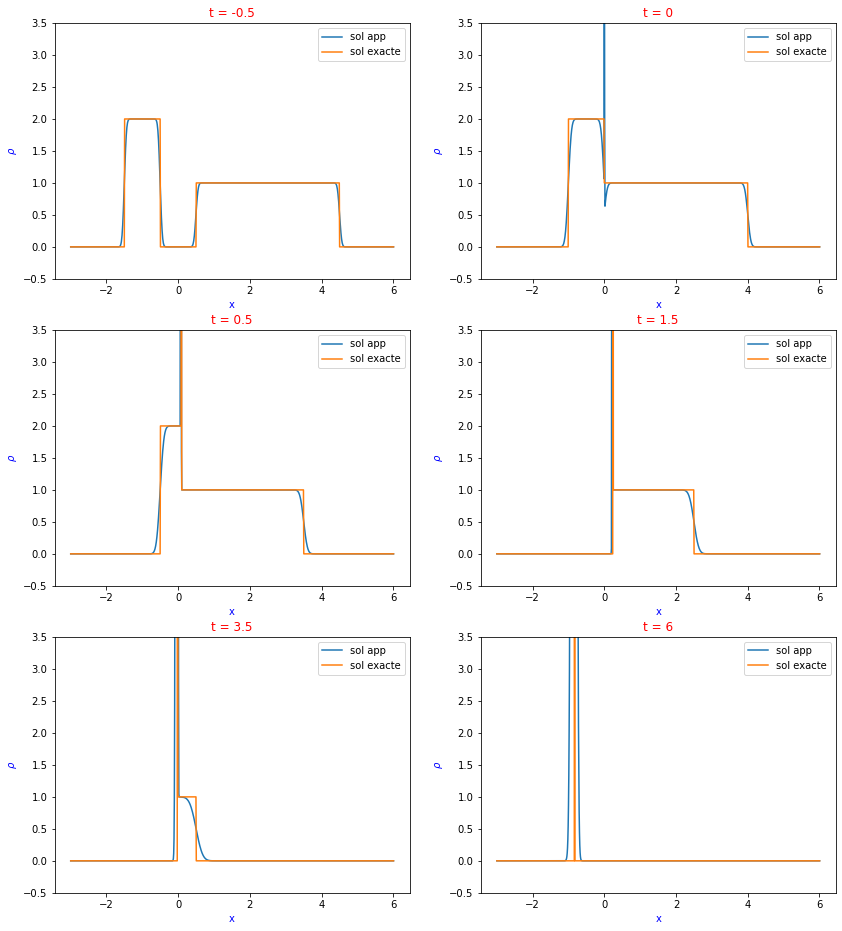

In [117]:
plt.figure(figsize=(14,16))

plt.subplot(321)
plt.title('t = -0.5',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[1],label = 'sol app')
plt.plot(x,Rho_ex[1],label = 'sol exacte')
plt.legend()

plt.subplot(322)
plt.title('t = 0',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[2],label = 'sol app')
plt.plot(x,Rho_ex[2],label = 'sol exacte')
plt.legend()

plt.subplot(323)
plt.title('t = 0.5',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[3],label = 'sol app')
plt.plot(x,Rho_ex[3],label = 'sol exacte')
plt.legend()

plt.subplot(324)
plt.title('t = 1.5',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[4],label = 'sol app')
plt.plot(x,Rho_ex[4],label = 'sol exacte')
plt.legend()

plt.subplot(325)
plt.title('t = 3.5',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[5],label = 'sol app')
plt.plot(x,Rho_ex[5],label = 'sol exacte')
plt.legend()

plt.subplot(326)
plt.title('t = 6',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho$',color = 'b')
plt.ylim(-0.5,3.5)
plt.plot(x,Rho[6],label = 'sol app')
plt.plot(x,Rho_ex[6],label = 'sol exacte')
plt.legend()

plt.show()

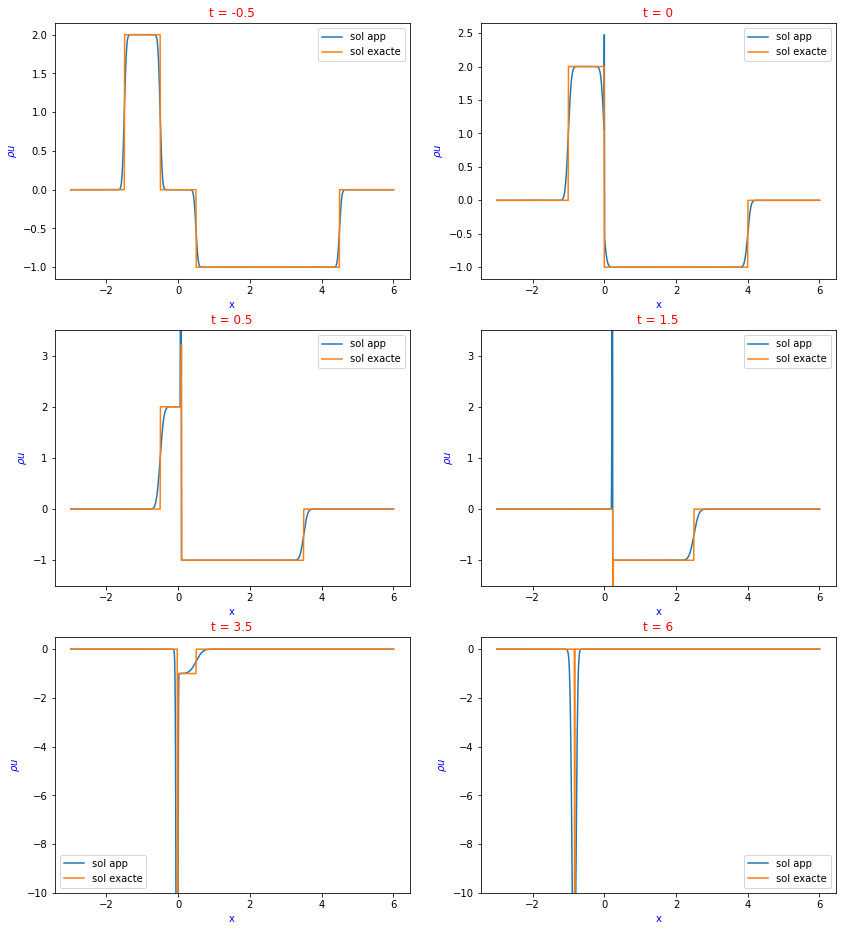

In [115]:
plt.figure(figsize=(14,16))

plt.subplot(321)
plt.title('t = -0.5',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[1],label = 'sol app')
plt.plot(x,Rhou_ex[1],label = 'sol exacte')
plt.legend()

plt.subplot(322)
plt.title('t = 0',color = 'r')
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[2],label = 'sol app')
plt.plot(x,Rhou_ex[2],label = 'sol exacte')
plt.legend()

plt.subplot(323)
plt.title('t = 0.5',color = 'r')
plt.ylim(-1.5,3.5)
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[3],label = 'sol app')
plt.plot(x,Rhou_ex[3],label = 'sol exacte')
plt.legend()

plt.subplot(324)
plt.title('t = 1.5',color = 'r')
plt.ylim(-1.5,3.5)
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[4],label = 'sol app')
plt.plot(x,Rhou_ex[4],label = 'sol exacte')
plt.legend()

plt.subplot(325)
plt.title('t = 3.5',color = 'r')
plt.ylim(-10,0.5)
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[5],label = 'sol app')
plt.plot(x,Rhou_ex[5],label = 'sol exacte')
plt.legend()

plt.subplot(326)
plt.title('t = 6',color = 'r')
plt.ylim(-10,0.5)
plt.xlabel('x',color = 'b')
plt.ylabel(r'$\rho u$',color = 'b')
plt.plot(x,Rhou[6],label = 'sol app')
plt.plot(x,Rhou_ex[6],label = 'sol exacte')
plt.legend()

plt.show()